## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

# Load transit time data from all three sheets
xl_file = 'data/colonial_transit_time.xlsx'

# Read data from each sheet
line1_data = pd.read_excel(xl_file, sheet_name='line1')
line3_data = pd.read_excel(xl_file, sheet_name='line3') 
line13_data = pd.read_excel(xl_file, sheet_name='line13')

print("Data loaded successfully:")
print(f"Line 1: {len(line1_data)} records")
print(f"Line 3: {len(line3_data)} records") 
print(f"Line 13: {len(line13_data)} records")

# Display first few rows of each dataset
print("\n=== Line 1 Data Sample ===")
display(line1_data.head())
print(f"Columns: {line1_data.columns.tolist()}")

print("\n=== Line 3 Data Sample ===")
display(line3_data.head())
print(f"Columns: {line3_data.columns.tolist()}")

print("\n=== Line 13 Data Sample ===") 
display(line13_data.head())
print(f"Columns: {line13_data.columns.tolist()}")

Data loaded successfully:
Line 1: 78 records
Line 3: 48 records
Line 13: 373 records

=== Line 1 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2024-08-22,HTN,GBJ,46,8,7,7,7,8.291667
1,2024-08-26,HTN,GBJ,47,7,6,7,10,7.250000
2,2024-08-29,HTN,GBJ,48,8,18,9,10,8.750000
3,2024-09-04,HTN,GBJ,49,7,6,9,10,7.250000
4,2024-09-08,HTN,GBJ,50,8,23,9,18,8.958333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']

=== Line 3 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2025-01-15,GBJ,HTN,3,7.0,17.0,3.0,11.0,7.708333
1,2025-01-21,GBJ,HTN,4,8.0,6.0,3.0,4.0,8.250000
2,2025-01-26,GBJ,HTN,5,8.0,5.0,NaN,NaN,8.208333
3,2025-02-02,GBJ,HTN,6,7.0,3.0,3.0,5.0,7.125000
4,2025-02-05,GBJ,HTN,7,5.0,8.0,2.0,18.0,5.333333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']

=== Line 13 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2020-07-01,HTN,LNJ,38,18,8,NaN,NaN,18.333333
1,2020-07-01,HTN,LNJ,39,18,5,NaN,NaN,18.208333
2,2020-07-01,HTN,LNJ,40,17,5,NaN,NaN,17.208333
3,2020-07-01,HTN,LNJ,41,17,22,NaN,NaN,17.916667
4,2020-07-01,HTN,LNJ,42,20,5,NaN,NaN,20.208333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']


## Step 1: Calculate Gas Transit Days

Converting the separate Gas Days and Gas Hours columns into a single decimal Gas Transit Days column for Line 1 and Line 3 data to match the Line 13 format. This will enable direct comparison across all three pipeline lines.

In [3]:
# Create Gas Transit Days column for Line 1 and Line 3 (similar to Line 13)
# Convert Gas Days + Gas Hours to decimal days
line1_data['Gas Transit Days'] = line1_data['Gas Days'] + line1_data['Gas Hours'] / 24
line3_data['Gas Transit Days'] = line3_data['Gas Days'] + line3_data['Gas Hours'] / 24

# Add year column for consistency
line1_data['Date'] = pd.to_datetime(line1_data['Date'])
line3_data['Date'] = pd.to_datetime(line3_data['Date'])
line13_data['Date'] = pd.to_datetime(line13_data['Date'])

line1_data['year'] = line1_data['Date'].dt.year
line3_data['year'] = line3_data['Date'].dt.year

print("Gas Transit Days calculated:")
display(line1_data['Gas Transit Days'].describe())
display(line3_data['Gas Transit Days'].describe())
display(line13_data['Gas Transit Days'].describe())

# Display sample with new column
print("\n=== Line 1 with Gas Transit Days ===")
display(line1_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

print("\n=== Line 3 with Gas Transit Days ===")
display(line3_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

Gas Transit Days calculated:


count    78.000000
mean      8.432692
std       0.803476
min       7.208333
25%       7.718750
50%       8.333333
75%       9.031250
max      11.250000
Name: Gas Transit Days, dtype: float64

count    47.000000
mean      5.178191
std       2.225319
min       0.333333
25%       3.979167
50%       5.041667
75%       6.604167
max      10.458333
Name: Gas Transit Days, dtype: float64

count    373.000000
mean      16.582440
std        4.073592
min        9.583333
25%       14.041667
50%       15.666667
75%       18.666667
max       38.125000
Name: Gas Transit Days, dtype: float64


=== Line 1 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2024-08-22,8,7,8.291667,2024
1,2024-08-26,7,6,7.250000,2024
2,2024-08-29,8,18,8.750000,2024
3,2024-09-04,7,6,7.250000,2024
4,2024-09-08,8,23,8.958333,2024



=== Line 3 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2025-01-15,7.0,17.0,7.708333,2025
1,2025-01-21,8.0,6.0,8.250000,2025
2,2025-01-26,8.0,5.0,8.208333,2025
3,2025-02-02,7.0,3.0,7.125000,2025
4,2025-02-05,5.0,8.0,5.333333,2025


## Step 2: Find Overlapping Time Periods

Identifying the common date range between Line 1 and Line 3 data to enable correlation analysis. This ensures we're comparing transit times from the same time periods.

In [4]:
# Correlation Analysis between different lines
# First, let's find overlapping time periods for correlation analysis

# Get date ranges for each dataset
print("Date Ranges:")
print(f"Line 1: {line1_data['Date'].min()} to {line1_data['Date'].max()}")
print(f"Line 3: {line3_data['Date'].min()} to {line3_data['Date'].max()}")
print(f"Line 13: {line13_data['Date'].min()} to {line13_data['Date'].max()}")

# Find common date range for Line 1 and Line 3 (most recent data)
line1_line3_start = max(line1_data['Date'].min(), line3_data['Date'].min())
line1_line3_end = min(line1_data['Date'].max(), line3_data['Date'].max())

print(f"\nOverlapping period for Line 1 & Line 3: {line1_line3_start} to {line1_line3_end}")

# Filter data for overlapping period
line1_overlap = line1_data[(line1_data['Date'] >= line1_line3_start) & (line1_data['Date'] <= line1_line3_end)].copy()
line3_overlap = line3_data[(line3_data['Date'] >= line1_line3_start) & (line3_data['Date'] <= line1_line3_end)].copy()

print(f"Overlapping records: Line 1={len(line1_overlap)}, Line 3={len(line3_overlap)}")

Date Ranges:
Line 1: 2024-08-22 00:00:00 to 2025-09-02 00:00:00
Line 3: 2025-01-15 00:00:00 to 2025-09-02 00:00:00
Line 13: 2020-07-01 00:00:00 to 2025-09-02 00:00:00

Overlapping period for Line 1 & Line 3: 2025-01-15 00:00:00 to 2025-09-02 00:00:00
Overlapping records: Line 1=48, Line 3=48


## Results Summary

The refactored analysis now tests **all possible combinations** of pipeline lines:

- **Line 1 vs Line 3**: Recent data (2025), both directions (HTN↔GBJ)
- **Line 1 vs Line 13**: Cross-validation using historical data (Line 13 goes to LNJ)
- **Line 3 vs Line 13**: Additional validation of reverse flow patterns


### Get merged pipeline data and Correlation

In [6]:
# Create helper functions for correlation and cointegration analysis
def analyze_correlation_pair(data1, data2, name1, name2, date_col='Date', value_col='Gas Transit Days'):
    """
    Analyze correlation between two pipeline datasets
    
    Parameters:
    - data1, data2: DataFrames with pipeline data
    - name1, name2: Names for the pipeline lines
    - date_col: Column name for dates
    - value_col: Column name for transit days
    
    Returns:
    - Dictionary with correlation results and pipeline data
    """
    # Find overlapping period
    start_date = max(data1[date_col].min(), data2[date_col].min())
    end_date = min(data1[date_col].max(), data2[date_col].max())
    
    # Filter to overlapping period
    data1_filtered = data1[(data1[date_col] >= start_date) & (data1[date_col] <= end_date)].copy()
    data2_filtered = data2[(data2[date_col] >= start_date) & (data2[date_col] <= end_date)].copy()
    
    # Merge on date for direct comparison - FIXED: Use same suffix format as visualization function
    merged = pd.merge(data1_filtered[[date_col, value_col]], 
                     data2_filtered[[date_col, value_col]], 
                     on=date_col, suffixes=(f'_{name1}', f'_{name2}'), how='inner')
    
    results = {
        'name1': name1,
        'name2': name2,
        'start_date': start_date,
        'end_date': end_date,
        'n_observations': len(merged),
        'merged_data': merged
    }
    
    if len(merged) > 2:
        # FIXED: Use correct column names that match the suffixes
        col1, col2 = f'{value_col}_{name1}', f'{value_col}_{name2}'
        
        # Remove NaN values before correlation calculation
        clean_merged = merged[[col1, col2]].dropna()
        
        if len(clean_merged) >= 3:  # Need at least 3 points for meaningful correlation
            # Calculate correlations
            pearson_r, pearson_p = pearsonr(clean_merged[col1], clean_merged[col2])
            spearman_r, spearman_p = spearmanr(clean_merged[col1], clean_merged[col2])
            
            results.update({
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'clean_observations': len(clean_merged)  # Add count of clean observations
            })
            
            # Test cointegration
            if len(clean_merged) > 10:
                try:
                    coint_stat, coint_p, coint_crit = coint(clean_merged[col1], clean_merged[col2])
                    results.update({
                        'coint_stat': coint_stat,
                        'coint_p': coint_p,
                        'coint_critical': coint_crit,
                        'is_cointegrated': coint_p < 0.05
                    })
                except Exception as e:
                    results['coint_error'] = str(e)
        else:
            results['insufficient_clean_data'] = f"Only {len(clean_merged)} clean observations available"
    
    return results

def print_correlation_results(results):
    """Print formatted correlation analysis results"""
    name1, name2 = results['name1'], results['name2']
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {name1} vs {name2}")
    print(f"{'='*60}")
    print(f"Period: {results['start_date'].date()} to {results['end_date'].date()}")
    print(f"Total paired observations: {results['n_observations']}")
    
    if 'clean_observations' in results:
        print(f"Clean observations (no NaN): {results['clean_observations']}")
    
    if 'pearson_r' in results:
        print(f"\nCorrelation Results:")
        print(f"  • Pearson:  r = {results['pearson_r']:.4f} (p = {results['pearson_p']:.4f})")
        print(f"  • Spearman: ρ = {results['spearman_r']:.4f} (p = {results['spearman_p']:.4f})")
        
        # Interpret strength
        r = abs(results['pearson_r'])
        if r > 0.7:
            strength = "Strong"
        elif r > 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
        direction = "positive" if results['pearson_r'] > 0 else "negative"
        print(f"  • Relationship: {strength} {direction} correlation")
        
        # Cointegration results
        if 'coint_stat' in results:
            print(f"\nCointegration Test:")
            print(f"  • ADF Statistic: {results['coint_stat']:.4f}")
            print(f"  • P-value: {results['coint_p']:.4f}")
            if results['is_cointegrated']:
                print(f"  • Result: 🎯 COINTEGRATED (long-term equilibrium exists)")
            else:
                print(f"  • Result: ❌ Not cointegrated")
        elif 'coint_error' in results:
            print(f"\nCointegration Test: Failed ({results['coint_error']})")
    elif 'insufficient_clean_data' in results:
        print(f"\n⚠️  {results['insufficient_clean_data']}")
    else:
        print("\n⚠️  Insufficient overlapping data for correlation analysis")

# Analyze all possible pairs
pipeline_data = {
    'Line1': line1_data,
    'Line3': line3_data, 
    'Line13': line13_data
}

# All combinations
pairs = [
    ('Line1', 'Line3'),
    ('Line1', 'Line13'), 
    ('Line3', 'Line13')
]

correlation_results = {}
for name1, name2 in pairs:
    results = analyze_correlation_pair(
        pipeline_data[name1], pipeline_data[name2], 
        name1, name2
    )
    correlation_results[f"{name1}_vs_{name2}"] = results
    print_correlation_results(results)


ANALYSIS: Line1 vs Line3
Period: 2025-01-15 to 2025-09-02
Total paired observations: 48
Clean observations (no NaN): 47

Correlation Results:
  • Pearson:  r = 0.1003 (p = 0.5024)
  • Spearman: ρ = 0.0713 (p = 0.6337)
  • Relationship: Weak positive correlation

Cointegration Test:
  • ADF Statistic: -2.7414
  • P-value: 0.1850
  • Result: ❌ Not cointegrated

ANALYSIS: Line1 vs Line13
Period: 2024-08-22 to 2025-09-02
Total paired observations: 54
Clean observations (no NaN): 54

Correlation Results:
  • Pearson:  r = 0.6165 (p = 0.0000)
  • Spearman: ρ = 0.5856 (p = 0.0000)
  • Relationship: Moderate positive correlation

Cointegration Test:
  • ADF Statistic: -4.5548
  • P-value: 0.0010
  • Result: 🎯 COINTEGRATED (long-term equilibrium exists)

ANALYSIS: Line3 vs Line13
Period: 2025-01-15 to 2025-09-02
Total paired observations: 48
Clean observations (no NaN): 47

Correlation Results:
  • Pearson:  r = 0.7028 (p = 0.0000)
  • Spearman: ρ = 0.6591 (p = 0.0000)
  • Relationship: Strong

### Do intial linear regression

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

def simple_regression(X, y):
    """
    Simple linear regression that returns model with residuals and fitted values
    
    Parameters:
    - X: predictor variable (array-like)  
    - y: response variable (array-like)
    
    Returns:
    - model object with .residuals and .fitted_values attributes
    """
    # Remove NaN values
    data = pd.DataFrame({'X': X, 'y': y}).dropna()
    X_clean = data['X'].values.reshape(-1, 1)
    y_clean = data['y'].values
    
    # Fit model
    model = LinearRegression().fit(X_clean, y_clean)
    
    # Add residuals and fitted values
    model.fitted_values = model.predict(X_clean)
    model.residuals = y_clean - model.fitted_values
    model.X = X_clean.flatten()
    model.y = y_clean
    
    # Print basic results
    r2 = model.score(X_clean, y_clean)
    print(f"R² = {r2:.4f}")
    print(f"Slope = {model.coef_[0]:.4f}")
    print(f"Intercept = {model.intercept_:.4f}")
    
    return model

def regression_plots(model, figsize=(12, 8)):
    """Create basic regression diagnostic plots"""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Scatter + regression line
    axes[0,0].scatter(model.X, model.y, alpha=0.6)
    axes[0,0].plot(model.X, model.fitted_values, 'r-', linewidth=2)
    axes[0,0].set_title('Regression Line')
    axes[0,0].set_xlabel('X')
    axes[0,0].set_ylabel('y')
    axes[0,0].grid(True, alpha=0.3)
    
    # Residuals vs fitted
    axes[0,1].scatter(model.fitted_values, model.residuals, alpha=0.6)
    axes[0,1].axhline(y=0, color='red', linestyle='--')
    axes[0,1].set_title('Residuals vs Fitted')
    axes[0,1].set_xlabel('Fitted Values')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].grid(True, alpha=0.3)
    
    # Q-Q plot
    stats.probplot(model.residuals, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot')
    axes[1,0].grid(True, alpha=0.3)
    
    # Histogram of residuals
    axes[1,1].hist(model.residuals, bins=20, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Residual Distribution')
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Example usage:
# model = simple_regression(X, y)
# regression_plots(model)



###  Test Assumptions

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

def test_stationarity(ts_data, column_name, max_lags=None, trend='c'):
    """
    Test stationarity of a time series using ADF and KPSS tests
    
    Parameters:
    - ts_data: pandas Series or DataFrame column with time series data
    - column_name: string name for the series (for reporting)
    - max_lags: maximum lags for ADF test (None for auto)
    - trend: trend assumption for tests ('c'=constant, 'ct'=constant+trend, 'n'=none)
    
    Returns:
    - Dictionary with test results
    """
    # Remove NaN values
    clean_data = ts_data.dropna()
    
    if len(clean_data) < 10:
        return {'error': f'Insufficient data points ({len(clean_data)}) for stationarity tests'}
    
    results = {
        'series_name': column_name,
        'n_observations': len(clean_data),
        'mean': clean_data.mean(),
        'std': clean_data.std(),
        'min': clean_data.min(),
        'max': clean_data.max()
    }
    
    try:
        # Augmented Dickey-Fuller test
        # H0: Unit root exists (non-stationary)
        # H1: No unit root (stationary)
        adf_result = adfuller(clean_data, maxlag=max_lags, regression=trend)
        
        results['adf'] = {
            'statistic': adf_result[0],
            'p_value': adf_result[1],
            'used_lag': adf_result[2],
            'n_obs': adf_result[3],
            'critical_values': adf_result[4],
            'is_stationary': adf_result[1] < 0.05,
            'conclusion': 'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'
        }
        
    except Exception as e:
        results['adf'] = {'error': str(e)}
    
    try:
        # KPSS test  
        # H0: Series is stationary
        # H1: Series is non-stationary
        kpss_result = kpss(clean_data, regression=trend, nlags='auto')
        
        results['kpss'] = {
            'statistic': kpss_result[0],
            'p_value': kpss_result[1],
            'lags_used': kpss_result[2],
            'critical_values': kpss_result[3],
            'is_stationary': kpss_result[1] > 0.05,
            'conclusion': 'Stationary' if kpss_result[1] > 0.05 else 'Non-stationary'
        }
        
    except Exception as e:
        results['kpss'] = {'error': str(e)}
    
    # Overall conclusion
    if 'error' not in results['adf'] and 'error' not in results['kpss']:
        adf_stat = results['adf']['is_stationary']
        kpss_stat = results['kpss']['is_stationary']
        
        if adf_stat and kpss_stat:
            results['overall_conclusion'] = 'STATIONARY (both tests agree)'
        elif not adf_stat and not kpss_stat:
            results['overall_conclusion'] = 'NON-STATIONARY (both tests agree)'
        else:
            results['overall_conclusion'] = 'INCONCLUSIVE (tests disagree)'
    
    return results

def print_stationarity_results(results):
    """Print formatted stationarity test results"""
    print(f"\n{'='*70}")
    print(f"STATIONARITY ANALYSIS: {results['series_name']}")
    print(f"{'='*70}")
    print(f"Data Summary:")
    print(f"  • Observations: {results['n_observations']}")
    print(f"  • Mean: {results['mean']:.4f}")
    print(f"  • Std Dev: {results['std']:.4f}")
    print(f"  • Range: [{results['min']:.4f}, {results['max']:.4f}]")
    
    if 'adf' in results and 'error' not in results['adf']:
        adf = results['adf']
        print(f"\n🔍 Augmented Dickey-Fuller Test:")
        print(f"  • Test Statistic: {adf['statistic']:.6f}")
        print(f"  • P-value: {adf['p_value']:.6f}")
        print(f"  • Lags Used: {adf['used_lag']}")
        print(f"  • Critical Values:")
        for level, cv in adf['critical_values'].items():
            print(f"    - {level}: {cv:.6f}")
        print(f"  • Conclusion: {adf['conclusion']} (p {'<' if adf['is_stationary'] else '≥'} 0.05)")
    
    if 'kpss' in results and 'error' not in results['kpss']:
        kpss = results['kpss']
        print(f"\n📊 KPSS Test:")
        print(f"  • Test Statistic: {kpss['statistic']:.6f}")
        print(f"  • P-value: {kpss['p_value']:.6f}")
        print(f"  • Lags Used: {kpss['lags_used']}")
        print(f"  • Critical Values:")
        for level, cv in kpss['critical_values'].items():
            print(f"    - {level}%: {cv:.6f}")
        print(f"  • Conclusion: {kpss['conclusion']} (p {'>' if kpss['is_stationary'] else '≤'} 0.05)")
    
    if 'overall_conclusion' in results:
        print(f"\n🎯 OVERALL CONCLUSION: {results['overall_conclusion']}")

def model_diagnostic_plots(residuals, fitted_values=None, series_name="Model", figsize=(15, 12)):
    """
    Create comprehensive diagnostic plots for model residuals (similar to ggplot's residual plots)
    
    Parameters:
    - residuals: array-like, model residuals
    - fitted_values: array-like, fitted values (optional)
    - series_name: string, name for the model/series
    - figsize: tuple, figure size
    
    Returns:
    - matplotlib figure object
    """
    # Clean the data
    residuals_clean = pd.Series(residuals).dropna()
    
    if fitted_values is not None:
        fitted_clean = pd.Series(fitted_values).dropna()
        # Ensure same length
        min_len = min(len(residuals_clean), len(fitted_clean))
        residuals_clean = residuals_clean.iloc[:min_len]
        fitted_clean = fitted_clean.iloc[:min_len]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'{series_name} - Model Diagnostic Plots', fontsize=16, fontweight='bold')
    
    # 1. Residuals vs Time (or Index)
    ax1 = axes[0, 0]
    time_index = range(len(residuals_clean))
    ax1.plot(time_index, residuals_clean, 'o-', alpha=0.7, markersize=3, linewidth=0.8)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.set_title('Residuals vs Time')
    ax1.set_xlabel('Time Index')
    ax1.set_ylabel('Residuals')
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    if len(residuals_clean) > 2:
        z = np.polyfit(time_index, residuals_clean, 1)
        p = np.poly1d(z)
        ax1.plot(time_index, p(time_index), "b--", alpha=0.5, linewidth=1)
    
    # 2. ACF of residuals
    ax2 = axes[0, 1]
    try:
        plot_acf(residuals_clean, ax=ax2, lags=min(40, len(residuals_clean)//4), alpha=0.05)
        ax2.set_title('ACF of Residuals')
        ax2.grid(True, alpha=0.3)
    except:
        ax2.text(0.5, 0.5, 'ACF calculation failed', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('ACF of Residuals (Failed)')
    
    # 3. Histogram of residuals with normal overlay
    ax3 = axes[0, 2]
    ax3.hist(residuals_clean, bins=30, density=True, alpha=0.7, color='lightblue', edgecolor='black')
    
    # Overlay normal distribution
    mu, sigma = residuals_clean.mean(), residuals_clean.std()
    x = np.linspace(residuals_clean.min(), residuals_clean.max(), 100)
    normal_curve = stats.norm.pdf(x, mu, sigma)
    ax3.plot(x, normal_curve, 'r-', linewidth=2, label=f'Normal(μ={mu:.3f}, σ={sigma:.3f})')
    ax3.set_title('Residuals Distribution')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Q-Q plot
    ax4 = axes[1, 0]
    stats.probplot(residuals_clean, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normal)')
    ax4.grid(True, alpha=0.3)
    
    # 5. Residuals vs Fitted (if fitted values provided)
    ax5 = axes[1, 1]
    if fitted_values is not None:
        ax5.scatter(fitted_clean, residuals_clean, alpha=0.6, s=20)
        ax5.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax5.set_xlabel('Fitted Values')
        ax5.set_ylabel('Residuals')
        ax5.set_title('Residuals vs Fitted')
        ax5.grid(True, alpha=0.3)
        
        # Add lowess smoothing line if possible
        try:
            from statsmodels.nonparametric.smoothers_lowess import lowess
            smoothed = lowess(residuals_clean, fitted_clean, frac=0.3)
            ax5.plot(smoothed[:, 0], smoothed[:, 1], 'b-', linewidth=2, alpha=0.7)
        except:
            pass
    else:
        ax5.text(0.5, 0.5, 'Fitted values not provided', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Residuals vs Fitted (N/A)')
    
    # 6. PACF of residuals  
    ax6 = axes[1, 2]
    try:
        plot_pacf(residuals_clean, ax=ax6, lags=min(40, len(residuals_clean)//4), alpha=0.05)
        ax6.set_title('PACF of Residuals')
        ax6.grid(True, alpha=0.3)
    except:
        ax6.text(0.5, 0.5, 'PACF calculation failed', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('PACF of Residuals (Failed)')
    
    plt.tight_layout()
    return fig

def residual_tests(residuals, series_name="Model"):
    """
    Perform statistical tests on model residuals
    
    Parameters:
    - residuals: array-like, model residuals
    - series_name: string, name for reporting
    
    Returns:
    - Dictionary with test results
    """
    residuals_clean = pd.Series(residuals).dropna()
    
    results = {
        'series_name': series_name,
        'n_residuals': len(residuals_clean),
        'residual_stats': {
            'mean': residuals_clean.mean(),
            'std': residuals_clean.std(),
            'skewness': stats.skew(residuals_clean),
            'kurtosis': stats.kurtosis(residuals_clean),
            'min': residuals_clean.min(),
            'max': residuals_clean.max()
        }
    }
    
    # Normality tests
    if len(residuals_clean) > 7:
        # Shapiro-Wilk test (good for n < 5000)
        if len(residuals_clean) <= 5000:
            sw_stat, sw_p = stats.shapiro(residuals_clean)
            results['shapiro_wilk'] = {
                'statistic': sw_stat,
                'p_value': sw_p,
                'is_normal': sw_p > 0.05
            }
        
        # Jarque-Bera test
        jb_stat, jb_p = stats.jarque_bera(residuals_clean)
        results['jarque_bera'] = {
            'statistic': jb_stat,
            'p_value': jb_p,
            'is_normal': jb_p > 0.05
        }
    
    # Serial correlation test (Ljung-Box)
    if len(residuals_clean) > 10:
        try:
            lags = min(10, len(residuals_clean)//4)
            lb_result = acorr_ljungbox(residuals_clean, lags=lags, return_df=True)
            results['ljung_box'] = {
                'statistics': lb_result['lb_stat'].values,
                'p_values': lb_result['lb_pvalue'].values,
                'lags': list(range(1, lags + 1)),
                'any_significant': any(lb_result['lb_pvalue'] < 0.05),
                'autocorrelated': any(lb_result['lb_pvalue'] < 0.05)
            }
        except Exception as e:
            results['ljung_box'] = {'error': str(e)}
    
    return results

def print_residual_test_results(results):
    """Print formatted residual test results"""
    print(f"\n{'='*70}")
    print(f"RESIDUAL DIAGNOSTIC TESTS: {results['series_name']}")
    print(f"{'='*70}")
    
    stats_info = results['residual_stats']
    print(f"Residual Summary Statistics:")
    print(f"  • Count: {results['n_residuals']}")
    print(f"  • Mean: {stats_info['mean']:.6f}")
    print(f"  • Std Dev: {stats_info['std']:.6f}")
    print(f"  • Skewness: {stats_info['skewness']:.4f}")
    print(f"  • Kurtosis: {stats_info['kurtosis']:.4f}")
    print(f"  • Range: [{stats_info['min']:.4f}, {stats_info['max']:.4f}]")
    
    # Normality tests
    if 'shapiro_wilk' in results:
        sw = results['shapiro_wilk']
        print(f"\n🔍 Shapiro-Wilk Normality Test:")
        print(f"  • Statistic: {sw['statistic']:.6f}")
        print(f"  • P-value: {sw['p_value']:.6f}")
        print(f"  • Conclusion: {'Normal' if sw['is_normal'] else 'Not Normal'} (α = 0.05)")
    
    if 'jarque_bera' in results:
        jb = results['jarque_bera']
        print(f"\n📊 Jarque-Bera Normality Test:")
        print(f"  • Statistic: {jb['statistic']:.6f}")
        print(f"  • P-value: {jb['p_value']:.6f}")
        print(f"  • Conclusion: {'Normal' if jb['is_normal'] else 'Not Normal'} (α = 0.05)")
    
    # Serial correlation
    if 'ljung_box' in results and 'error' not in results['ljung_box']:
        lb = results['ljung_box']
        print(f"\n🔄 Ljung-Box Serial Correlation Test:")
        print(f"  • Lags tested: {lb['lags']}")
        print(f"  • Any significant autocorrelation: {'Yes' if lb['autocorrelated'] else 'No'}")
        if lb['autocorrelated']:
            significant_lags = [lag for lag, p in zip(lb['lags'], lb['p_values']) if p < 0.05]
            print(f"  • Significant lags: {significant_lags}")

# Example usage functions
def analyze_pipeline_stationarity(pipeline_data):
    """Analyze stationarity for all pipeline data"""
    print("🔍 STATIONARITY ANALYSIS FOR ALL PIPELINES")
    print("="*80)
    
    stationarity_results = {}
    for line_name, data in pipeline_data.items():
        clean_data = data['Gas Transit Days'].dropna()
        if len(clean_data) >= 10:
            results = test_stationarity(clean_data, f"{line_name} Transit Days")
            stationarity_results[line_name] = results
            print_stationarity_results(results)
        else:
            print(f"\n⚠️  {line_name}: Insufficient data ({len(clean_data)} points) for stationarity tests")
    
    return stationarity_results

def create_comprehensive_diagnostics(residuals, fitted_values=None, series_name="Model"):
    """Create both visual and statistical diagnostics"""
    # Visual diagnostics
    fig = model_diagnostic_plots(residuals, fitted_values, series_name)
    
    # Statistical tests
    test_results = residual_tests(residuals, series_name)
    print_residual_test_results(test_results)
    
    return fig, test_results

stationarity_results = analyze_pipeline_stationarity(pipeline_data)
# Use with your diagnostic functions:
# model = simple_regression(X, y)
# fig, tests = create_comprehensive_diagnostics(model.residuals, model.fitted_values)

🔍 STATIONARITY ANALYSIS FOR ALL PIPELINES

STATIONARITY ANALYSIS: Line1 Transit Days
Data Summary:
  • Observations: 78
  • Mean: 8.4327
  • Std Dev: 0.8035
  • Range: [7.2083, 11.2500]

🔍 Augmented Dickey-Fuller Test:
  • Test Statistic: -2.861060
  • P-value: 0.050067
  • Lags Used: 1
  • Critical Values:
    - 1%: -3.519481
    - 5%: -2.900395
    - 10%: -2.587498
  • Conclusion: Non-stationary (p ≥ 0.05)

📊 KPSS Test:
  • Test Statistic: 0.848245
  • P-value: 0.010000
  • Lags Used: 4
  • Critical Values:
    - 10%%: 0.347000
    - 5%%: 0.463000
    - 2.5%%: 0.574000
    - 1%%: 0.739000
  • Conclusion: Non-stationary (p ≤ 0.05)

🎯 OVERALL CONCLUSION: NON-STATIONARY (both tests agree)

STATIONARITY ANALYSIS: Line3 Transit Days
Data Summary:
  • Observations: 47
  • Mean: 5.1782
  • Std Dev: 2.2253
  • Range: [0.3333, 10.4583]

🔍 Augmented Dickey-Fuller Test:
  • Test Statistic: -4.869395
  • P-value: 0.000040
  • Lags Used: 0
  • Critical Values:
    - 1%: -3.581258
    - 5%: -2.926

## Pairs Charts

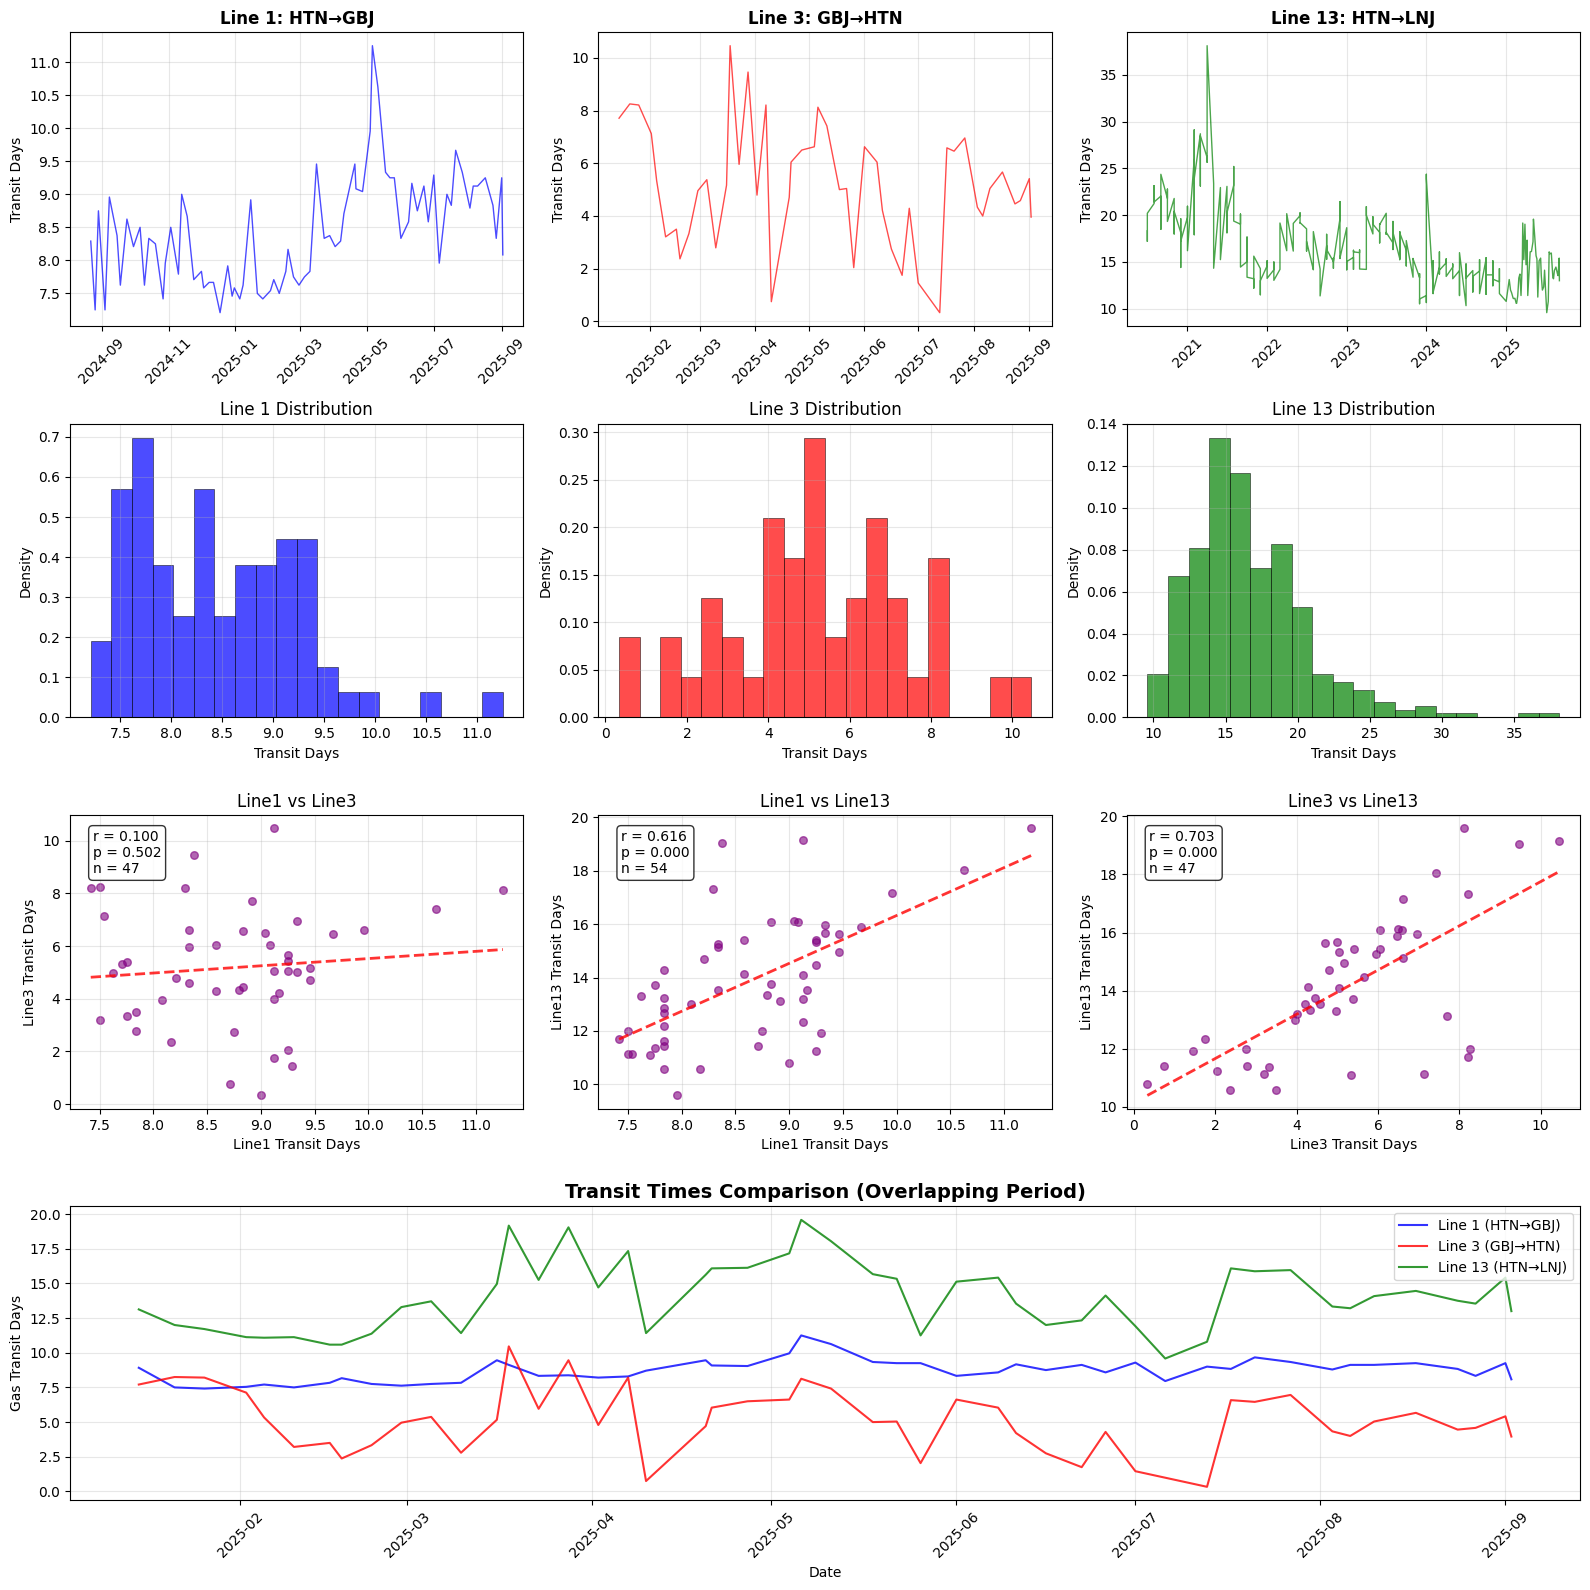


📊 Transit Time Correlation Matrix Analysis Complete!

This visualization shows:
• Row 1: Individual time series for each pipeline line
• Row 2: Distribution histograms showing transit time patterns
• Row 3: Scatter plots with regression lines for all pair combinations
• Row 4: Overlay plot showing all lines during their common time period


In [13]:
# Create comprehensive pairwise visualization (similar to ggpairs in R)
def create_transit_correlation_matrix(correlation_results, pipeline_data):
    """Create a comprehensive pairwise plot matrix with the function resul"""
    
    # Set up the plot grid (4x4 for comprehensive view)
    fig = plt.figure(figsize=(16, 16))
    
    # Define line info for labeling
    line_info = {
        'Line1': {'name': 'Line 1', 'route': 'HTN→GBJ', 'color': 'blue'},
        'Line3': {'name': 'Line 3', 'route': 'GBJ→HTN', 'color': 'red'},
        'Line13': {'name': 'Line 13', 'route': 'HTN→LNJ', 'color': 'green'}
    }
    
    # Row 1: Individual time series
    for i, (line_key, line_data) in enumerate(pipeline_data.items()):
        ax = plt.subplot(4, 3, i + 1)
        # Filter out NaN values for plotting
        clean_data = line_data.dropna(subset=['Gas Transit Days'])
        if len(clean_data) > 0:
            ax.plot(clean_data['Date'], clean_data['Gas Transit Days'], 
                   color=line_info[line_key]['color'], alpha=0.7, linewidth=1)
        ax.set_title(f"{line_info[line_key]['name']}: {line_info[line_key]['route']}", 
                    fontweight='bold')
        ax.set_ylabel('Transit Days')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Row 2: Distribution histograms
    for i, (line_key, line_data) in enumerate(pipeline_data.items()):
        ax = plt.subplot(4, 3, i + 4)
        # Filter out NaN values for histogram
        clean_values = line_data['Gas Transit Days'].dropna()
        if len(clean_values) > 0:
            ax.hist(clean_values, bins=20, alpha=0.7, 
                   color=line_info[line_key]['color'], density=True, 
                   edgecolor='black', linewidth=0.5)
            ax.set_xlabel('Transit Days')
            ax.set_ylabel('Density')
        else:
            ax.text(0.5, 0.5, 'No valid data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12, color='gray')
        ax.set_title(f"{line_info[line_key]['name']} Distribution")
        ax.grid(True, alpha=0.3)
    
    # Row 3: Scatter plots for each pair with correlation
    scatter_positions = [7, 8, 9]  # positions for 3 scatter plots
    pair_keys = ['Line1_vs_Line3', 'Line1_vs_Line13', 'Line3_vs_Line13']
    
    for pos, key in zip(scatter_positions, pair_keys):
        ax = plt.subplot(4, 3, pos)
        results = correlation_results[key]
        
        # First, ensure we have proper merged data
        if 'merged_data' not in results or len(results['merged_data']) == 0:
            # Create merged data if missing
            line1_key = results['name1']
            line2_key = results['name2']
            if line1_key in pipeline_data and line2_key in pipeline_data:
                data1 = pipeline_data[line1_key][['Date', 'Gas Transit Days']].copy()
                data2 = pipeline_data[line2_key][['Date', 'Gas Transit Days']].copy()
                merged = pd.merge(data1, data2, on='Date', suffixes=(f'_{line1_key}', f'_{line2_key}'))
                results['merged_data'] = merged
        
        if 'merged_data' in results and len(results['merged_data']) > 0:
            merged = results['merged_data']
            col1 = f"Gas Transit Days_{results['name1']}"
            col2 = f"Gas Transit Days_{results['name2']}"
            
            # Remove NaN values and check for sufficient data
            clean_merged = merged[[col1, col2]].dropna()
            
            if len(clean_merged) >= 3:  # Need at least 3 points for regression
                ax.scatter(clean_merged[col1], clean_merged[col2], alpha=0.6, 
                          color='purple', s=30)
                
                # Check if correlation is nan and recalculate if needed
                r = results.get('pearson_r', np.nan)
                p_val = results.get('pearson_p', np.nan)
                
                if pd.isna(r) or pd.isna(p_val):
                    try:
                        from scipy.stats import pearsonr
                        r, p_val = pearsonr(clean_merged[col1], clean_merged[col2])
                        # Update the results dictionary
                        results['pearson_r'] = r
                        results['pearson_p'] = p_val
                        print(f"Recalculated correlation for {results['name1']} vs {results['name2']}: r = {r:.3f}")
                    except Exception as e:
                        print(f"Failed to recalculate correlation for {results['name1']} vs {results['name2']}: {e}")
                        r, p_val = np.nan, np.nan
                
                # Add regression line with error handling
                try:
                    x_vals = clean_merged[col1].values
                    y_vals = clean_merged[col2].values
                    
                    # Check for sufficient variation in x values
                    if np.std(x_vals) > 1e-10 and len(np.unique(x_vals)) > 1:
                        z = np.polyfit(x_vals, y_vals, 1)
                        p = np.poly1d(z)
                        x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
                        ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
                    else:
                        print(f"Warning: Insufficient variation in {results['name1']} data for regression")
                        
                except (np.linalg.LinAlgError, np.RankWarning) as e:
                    print(f"Warning: Could not fit regression line for {results['name1']} vs {results['name2']}: {e}")
                
                ax.set_xlabel(f"{results['name1']} Transit Days")
                ax.set_ylabel(f"{results['name2']} Transit Days")
                ax.set_title(f"{results['name1']} vs {results['name2']}")
                
                # Add correlation text with proper nan handling
                n_points = len(clean_merged)
                if not pd.isna(r):
                    ax.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.3f}\nn = {n_points}', 
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=10)
                else:
                    ax.text(0.05, 0.95, f'r = calculation failed\nn = {n_points}', 
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=10)
            else:
                ax.text(0.5, 0.5, f'Insufficient data\n({len(clean_merged)} points)', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, color='gray')
                ax.set_title(f"{results['name1']} vs {results['name2']}")
        else:
            ax.text(0.5, 0.5, 'No overlapping\ndata', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=12, color='gray')
            ax.set_title(f"{results['name1']} vs {results['name2']}")
        
        ax.grid(True, alpha=0.3)
    
    # Row 4: Combined time series overlay
    ax = plt.subplot(4, 1, 4)
    
    # Find common date range for overlay (only for lines with data)
    valid_data = {}
    for line_key, line_data in pipeline_data.items():
        clean_data = line_data.dropna(subset=['Gas Transit Days'])
        if len(clean_data) > 0:
            valid_data[line_key] = clean_data
    
    if len(valid_data) > 1:
        common_start = max(data['Date'].min() for data in valid_data.values())
        common_end = min(data['Date'].max() for data in valid_data.values())
        
        for line_key, line_data in valid_data.items():
            # Filter to common period for better comparison
            filtered_data = line_data[(line_data['Date'] >= common_start) & 
                                     (line_data['Date'] <= common_end)]
            if len(filtered_data) > 0:
                ax.plot(filtered_data['Date'], filtered_data['Gas Transit Days'], 
                       color=line_info[line_key]['color'], alpha=0.8, linewidth=1.5,
                       label=f"{line_info[line_key]['name']} ({line_info[line_key]['route']})")
        
        ax.set_title('Transit Times Comparison (Overlapping Period)', fontweight='bold', fontsize=14)
        ax.legend(loc='upper right')
    else:
        # Plot individual series even if no overlap
        for line_key, line_data in valid_data.items():
            ax.plot(line_data['Date'], line_data['Gas Transit Days'], 
                   color=line_info[line_key]['color'], alpha=0.8, linewidth=1.5,
                   label=f"{line_info[line_key]['name']} ({line_info[line_key]['route']})")
        
        ax.set_title('Transit Times (Individual Series)', fontweight='bold', fontsize=14)
        if valid_data:
            ax.legend(loc='upper right')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Gas Transit Days')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the comprehensive transit correlation matrix with robust error handling

correlation_matrix_fig = create_transit_correlation_matrix(correlation_results, pipeline_data)
print("\n📊 Transit Time Correlation Matrix Analysis Complete!")
print("\nThis visualization shows:")
print("• Row 1: Individual time series for each pipeline line")
print("• Row 2: Distribution histograms showing transit time patterns")  
print("• Row 3: Scatter plots with regression lines for all pair combinations")
print("• Row 4: Overlay plot showing all lines during their common time period")


In [ ]:
# Create comprehensive summary table with proper NaN handling
def create_summary_table(correlation_results):
    """Create a summary table of all correlation analyses with robust error handling"""
    summary_data = []
    
    for key, results in correlation_results.items():
        # Helper function to format numbers or return 'nan'
        def format_number(value, decimals=3):
            if pd.isna(value) or value != value:  # Check for NaN
                return 'nan'
            return f"{value:.{decimals}f}"
        
        # Helper function to format p-values
        def format_pvalue(value):
            if pd.isna(value) or value != value:
                return 'nan'
            if value < 0.001:
                return '0.000'
            return f"{value:.3f}"
        
        if 'pearson_r' in results and not pd.isna(results.get('pearson_r')):
            # Has valid correlation data
            summary_data.append({
                'Pair': f"{results['name1']} vs {results['name2']}",
                'Period': f"{results['start_date'].date()} to {results['end_date'].date()}",
                'N': results['n_observations'],
                'Pearson r': format_number(results['pearson_r']),
                'P-value': format_pvalue(results['pearson_p']),
                'Spearman ρ': format_number(results.get('spearman_r', float('nan'))),
                'Cointegrated': '✅' if results.get('is_cointegrated', False) else '❌',
                'Coint p-value': format_pvalue(results.get('coint_p', float('nan')))
            })
        else:
            # No valid correlation data
            summary_data.append({
                'Pair': f"{results['name1']} vs {results['name2']}",
                'Period': f"{results['start_date'].date()} to {results['end_date'].date()}",
                'N': results['n_observations'],
                'Pearson r': 'nan',
                'P-value': 'nan',
                'Spearman ρ': 'nan',
                'Cointegrated': '❌',
                'Coint p-value': 'N/A'
            })
    
    return pd.DataFrame(summary_data)

def create_stats_table(pipeline_data):
    """Create statistics table for all pipeline lines"""
    stats_data = []
    route_map = {
        'Line1': 'HTN → GBJ',
        'Line3': 'GBJ → HTN', 
        'Line13': 'HTN → LNJ'
    }
    
    for name, data in pipeline_data.items():
        transit_days = data['Gas Transit Days'].dropna()  # Remove NaN values
        
        if len(transit_days) > 0:
            stats_data.append({
                'Line': name,
                'Route': route_map[name],
                'Records': len(transit_days),
                'Mean (days)': f"{transit_days.mean():.2f}",
                'Std (days)': f"{transit_days.std():.2f}",
                'Min (days)': f"{transit_days.min():.2f}",
                'Max (days)': f"{transit_days.max():.2f}",
                'Date Range': f"{data['Date'].min().date()} to {data['Date'].max().date()}"
            })
        else:
            stats_data.append({
                'Line': name,
                'Route': route_map[name],
                'Records': 0,
                'Mean (days)': 'N/A',
                'Std (days)': 'N/A',
                'Min (days)': 'N/A',
                'Max (days)': 'N/A',
                'Date Range': 'No data'
            })
    
    return pd.DataFrame(stats_data)

# Generate the summary tables
print("\n" + "="*80)
print("COMPREHENSIVE CORRELATION SUMMARY")
print("="*80)

summary_df = create_summary_table(correlation_results)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("TRANSIT TIME STATISTICS BY LINE") 
print("="*80)

stats_df = create_stats_table(pipeline_data)
print(stats_df.to_string(index=False))

# Additional insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Count significant correlations
significant_correlations = 0
total_correlations = 0

for key, results in correlation_results.items():
    if 'pearson_p' in results and not pd.isna(results['pearson_p']):
        total_correlations += 1
        if results['pearson_p'] < 0.05:
            significant_correlations += 1

print(f"• Total correlation pairs analyzed: {len(correlation_results)}")
print(f"• Pairs with valid correlations: {total_correlations}")
print(f"• Statistically significant correlations (p < 0.05): {significant_correlations}")

# Identify strongest correlations
valid_correlations = []
for key, results in correlation_results.items():
    if 'pearson_r' in results and not pd.isna(results['pearson_r']):
        valid_correlations.append((key, abs(results['pearson_r']), results['pearson_r']))

if valid_correlations:
    strongest = max(valid_correlations, key=lambda x: x[1])
    print(f"• Strongest correlation: {strongest[0]} (r = {strongest[2]:.3f})")

# Cointegration summary
cointegrated_pairs = [key for key, results in correlation_results.items() 
                     if results.get('is_cointegrated', False)]
if cointegrated_pairs:
    print(f"• Cointegrated pairs: {len(cointegrated_pairs)} ({', '.join(cointegrated_pairs)})")
else:
    print("• No cointegrated pairs detected")